## Imports

In [101]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
from my_utils import select_k_best

In [102]:
df_awards_players = pd.read_csv('data/awards_players_processed.csv')
df_coaches_before = pd.read_csv('data/coaches.csv')
df_players_teams_before = pd.read_csv('data/players_teams.csv')
df_players = pd.read_csv('data/players_processed.csv')
df_series_post = pd.read_csv('data/series_post_processed.csv')
df_teams_before = pd.read_csv('data/teams.csv')
df_teams_post = pd.read_csv('data/teams_post_processed.csv')
df_teams_11 = pd.read_csv('data/11year/teams.csv')
df_players_teams_11 = pd.read_csv('data/11year/players_teams.csv')
df_coaches_11 = pd.read_csv('data/11year/coaches.csv')

## Clean up 11 year data

In [103]:

def drop_columns_with_all_nan(df):
    # Step 1: Check for columns with all NaN values
    columns_to_drop = []
    for col in df.columns:
        unique_values = df[col].unique()
        if len(unique_values) == 1 or all(pd.isna(x) for x in unique_values):
            columns_to_drop.append(col)

    # Step 2: Drop identified columns
    df.drop(columns=columns_to_drop, inplace=True)

    # Step 3: Print the identified columns to be dropped
    print(columns_to_drop)




In [104]:
drop_columns_with_all_nan(df_teams_before)
print(df_teams_before.duplicated().sum())
df_teams_before.drop_duplicates(inplace=True)


drop_columns_with_all_nan(df_players_teams_before)
print(df_players_teams_before.duplicated().sum())
df_players_teams_before.drop_duplicates(inplace=True)

drop_columns_with_all_nan(df_coaches_before)
print(df_coaches_before.duplicated().sum())
print(df_coaches_before.duplicated(subset=['tmID', 'year']).sum())
df_coaches_before.drop_duplicates(inplace=True)




['lgID', 'divID', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB']
0
['lgID']
0
['lgID']
0
20


In [105]:
df_teams_11.drop(['lgID','franchID','name','arena'], axis=1, inplace=True)
df_players_teams_11.drop(['stint','lgID'], axis=1, inplace=True)
df_coaches_11.drop(['stint','lgID'], axis=1, inplace=True)

## Shilf data from the teams, palyers and coaches, with the 11 year

Join the teams data with the 11 year team data. Then shift the data calculating the average of the two previous years.

In [106]:
# concat df_teams_11 and df_teams with the common columns and the rest of the columns 0
df_teams_before = pd.concat([df_teams_before, df_teams_11], axis=0, ignore_index=True)
df_teams_before.fillna(0, inplace=True)

In [107]:
df_teams_before['playoff'] = df_teams_before['playoff'].map({'N': 0, 'Y': 1})
years = df_teams_before['year'].unique()
teams = df_teams_before['tmID'].unique()
df_teams_before.sort_values(by=['year', 'tmID'], ascending=[True, True], inplace=True)

years_back = 2

df_teams = df_teams_before.copy()

average_collumns = ["homeW","homeL","awayW","awayL","confW","confL","min","attend"]

for year in years:
    for team in teams:
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'num_playoff_appearances'] = df_teams_before[(df_teams_before['year'] >= (year - years_back)) & (df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['playoff'].sum()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'total_first_round_won'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['firstRound'] == 'W').sum()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'total_first_round_lost'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['firstRound'] == 'L').sum()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'total_semis_won'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['semis'] == 'W').sum()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'total_semis_lost'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['semis'] == 'L').sum()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'total_finals_won'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['finals'] == 'W').sum()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'total_finals_lost'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['finals'] == 'L').sum()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'mean_won'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['won']).mean()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'mean_lost'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['lost']).mean()
        df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), 'rank'] = (df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)]['rank']).mean()
        for column in average_collumns:
            df_teams.loc[(df_teams['year'] == year) & (df_teams['tmID'] == team), column] = df_teams_before[(df_teams_before['year'] >= (year - years_back)) &(df_teams_before['year'] < year) & (df_teams_before['tmID'] == team)][column].mean()
 
         
df_teams.drop(columns=['firstRound', 'semis', 'finals',"won","lost", 'franchID', 'name', 'arena', "o_fgm","o_fga","o_ftm","o_fta","o_3pm","o_3pa","o_oreb","o_dreb","o_reb","o_asts","o_pf","o_stl","o_to","o_blk","o_pts","d_fgm","d_fga","d_ftm","d_fta","d_3pm","d_3pa","d_oreb","d_dreb","d_reb","d_asts","d_pf","d_stl","d_to","d_blk","d_pts","GP"], inplace=True)
df_teams.fillna(0, inplace=True)   

encoder = OneHotEncoder()
categorical_features = ['confID']
for feature in categorical_features:
    onehotarray = encoder.fit_transform(df_teams[[feature]]).toarray()
    items = [f'{feature}_{item}' for item in encoder.categories_[0]]
    df_teams[items] = onehotarray
df_teams=df_teams.drop(categorical_features, axis=1)

Join the the players teams data with the 11 year players data. Then shift the data calculating the average of the two previous years.

In [108]:
df_players_teams_before = pd.concat([df_players_teams_before, df_players_teams_11], axis=0, ignore_index=True)
df_players_teams_before.fillna(0, inplace=True)

In basketball, one can calculate the total points scored using the following formula:
Total Points = Free Throws Made (ftMade) + 2 * (Field Goals Made (fgMade) - Three-Pointers Made (threeMade)) + 3 * Three-Pointers Made (threeMade).
However, it's important to note that the given dataset already includes a dedicated column for total points. Consequently, the columns for Free Throws Made (ftMade), Field Goals Made (fgMade), and Three-Pointers Made (threeMade)  end up giving redundant information, and therefore, are not useful and can be deleted from the dataset.

In [109]:

df_players_teams_before['Postperformance'] = (df_players_teams_before['PostPoints'] + df_players_teams_before['PostRebounds'] +
                           df_players_teams_before['PostAssists'] + df_players_teams_before['PostSteals'] +
                           df_players_teams_before['PostBlocks']) - (df_players_teams_before['PostTurnovers'] +
                           0.4*df_players_teams_before['PostPF'])   
df_players_teams_before['performance'] = (df_players_teams_before['points'] + df_players_teams_before['rebounds'] +
                           df_players_teams_before['assists'] + df_players_teams_before['steals'] +
                           df_players_teams_before['blocks']) - (df_players_teams_before['turnovers'] +
                           0.4*df_players_teams_before['PF'])   
points_made = 1 * df_players_teams_before['ftMade'] + 2 * (df_players_teams_before['fgMade'] - df_players_teams_before['threeMade']) + 3 * df_players_teams_before['threeMade']
points_attempted = 1 * df_players_teams_before['ftAttempted'] + 2 * (df_players_teams_before['fgAttempted'] - df_players_teams_before['threeAttempted']) + 3 * df_players_teams_before['threeAttempted']
df_players_teams_before['points_precision'] = points_attempted - points_made

post_points_made = 1 * df_players_teams_before['PostftMade'] + 2 * (df_players_teams_before['PostfgMade'] - df_players_teams_before['PostthreeMade']) + 3 * df_players_teams_before['PostthreeMade']
post_points_attempted = 1 * df_players_teams_before['PostftAttempted'] + 2 * (df_players_teams_before['PostfgAttempted'] - df_players_teams_before['PostthreeAttempted']) + 3 * df_players_teams_before['PostthreeAttempted']
df_players_teams_before['Postpoints_precision'] = post_points_attempted - post_points_made

df_players_teams_before.drop(columns=['points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'PostPoints', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF'], inplace=True)
df_players_teams_before.drop(columns=['ftMade', 'fgMade', 'threeMade', 'fgAttempted', 'ftAttempted', 'threeAttempted', 'PostftMade', 'PostfgMade', 'PostthreeMade', 'PostfgAttempted', 'PostftAttempted', 'PostthreeAttempted'], inplace=True)

In [110]:
df_players_teams = df_players_teams_before.copy()

average_collumns = ["GP","GS","minutes","oRebounds","dRebounds","dq","PostGP","PostGS","PostMinutes","PostoRebounds","PostdRebounds","PostDQ", 'performance','Postperformance', 'points_precision', 'Postpoints_precision' ]
for year in years:
    for team in teams:
        players = df_players_teams_before[(df_players_teams_before['year'] == year) & (df_players_teams_before['tmID'] == team)]['playerID'].unique()
        for player in players:
            for column in average_collumns:
                df_players_teams.loc[(df_players_teams['year'] == year) & (df_players_teams['tmID'] == team) & (df_players_teams['playerID'] == player), column] = df_players_teams_before[(df_players_teams['year'] >= (year - years_back)) &(df_players_teams['year'] < year)  & (df_players_teams['playerID'] == player)][column].mean()

df_players_teams.dropna(inplace=True)
df_players_teams.drop(columns=['stint'], inplace=True)

print(df_players_teams_before.info(), df_players_teams.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   playerID              2024 non-null   object 
 1   year                  2024 non-null   int64  
 2   stint                 2024 non-null   float64
 3   tmID                  2024 non-null   object 
 4   GP                    2024 non-null   float64
 5   GS                    2024 non-null   float64
 6   minutes               2024 non-null   float64
 7   oRebounds             2024 non-null   float64
 8   dRebounds             2024 non-null   float64
 9   dq                    2024 non-null   float64
 10  PostGP                2024 non-null   float64
 11  PostGS                2024 non-null   float64
 12  PostMinutes           2024 non-null   float64
 13  PostoRebounds         2024 non-null   float64
 14  PostdRebounds         2024 non-null   float64
 15  PostDQ               

Join the the coaches data with the 11 year coaches data. Then shift the data calculating the average of the two previous years.

In [111]:
df_coaches_before = pd.concat([df_coaches_before,df_coaches_11], axis=0, ignore_index=True)
df_coaches_before.fillna(0, inplace=True)

In [112]:
df_coaches = df_coaches_before.copy()

average_collumns = ["won","lost","post_wins","post_losses"]
for year in years:
    for team in teams:
        coaches= df_coaches_before[(df_coaches_before['year'] == year) & (df_coaches_before['tmID'] == team)]['coachID'].unique()
        for coach in coaches:
            for column in average_collumns:
                df_coaches.loc[(df_coaches['year'] == year) & (df_coaches['tmID'] == team) & (df_coaches['coachID'] == coach), column] = df_coaches_before[(df_coaches_before['year'] >= (year - years_back)) &(df_coaches_before['year'] < year) & (df_coaches_before['coachID'] == coach)][column].mean()         

df_coaches.fillna(0, inplace=True)


## Merge

Agregate data from players team, players info and awards

In [113]:
players_teams_info_df = pd.merge(df_players_teams, df_players, left_on='playerID', right_on='bioID', how='left')
players_teams_info_df = pd.merge(players_teams_info_df, df_awards_players, on=['playerID', 'year'], how='left').fillna(0)
players_teams_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   playerID              1392 non-null   object 
 1   year                  1392 non-null   int64  
 2   tmID                  1392 non-null   object 
 3   GP                    1392 non-null   float64
 4   GS                    1392 non-null   float64
 5   minutes               1392 non-null   float64
 6   oRebounds             1392 non-null   float64
 7   dRebounds             1392 non-null   float64
 8   dq                    1392 non-null   float64
 9   PostGP                1392 non-null   float64
 10  PostGS                1392 non-null   float64
 11  PostMinutes           1392 non-null   float64
 12  PostoRebounds         1392 non-null   float64
 13  PostdRebounds         1392 non-null   float64
 14  PostDQ                1392 non-null   float64
 15  Postperformance      

For each team and year agregate the statistics of the players in the team and join it to the Teams dataset.

In [114]:
agg_players_df = players_teams_info_df.groupby(["year", "tmID"]).agg({
    "GP": "mean",
    "GS": "mean",
    "minutes": "mean",
    "oRebounds": "mean",
    "dRebounds": "mean",
    "dq": "mean",
    "PostGP": "mean",
    "PostGS": "mean",
    "PostMinutes": "mean",
    "PostoRebounds": "mean",
    "PostdRebounds": "mean",
    "performance": "mean",
    "Postperformance": "mean",
    'points_precision': 'mean',
    'Postpoints_precision': 'mean',
    "PostDQ": "mean",
    "height": "mean",
    "weight": "mean",
    "award_count": "mean",
    # Add more columns you want to aggregate here
}).reset_index()

df_teams = pd.merge(df_teams, agg_players_df, on=['year', 'tmID'], how='left').fillna(0)
#agg_players_df.head()

In [115]:
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     154 non-null    int64  
 1   tmID                     154 non-null    object 
 2   rank                     154 non-null    float64
 3   playoff                  154 non-null    float64
 4   homeW                    154 non-null    float64
 5   homeL                    154 non-null    float64
 6   awayW                    154 non-null    float64
 7   awayL                    154 non-null    float64
 8   confW                    154 non-null    float64
 9   confL                    154 non-null    float64
 10  min                      154 non-null    float64
 11  attend                   154 non-null    float64
 12  num_playoff_appearances  154 non-null    float64
 13  total_first_round_won    154 non-null    float64
 14  total_first_round_lost   1

Merge the coaches data with the awards they have won.

In [116]:
df_coaches_with_awards = pd.merge(df_coaches, df_awards_players, left_on=['coachID', 'year'], right_on=['playerID', 'year'], how='left').fillna(0)
df_coaches_with_awards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   coachID      176 non-null    object 
 1   year         176 non-null    int64  
 2   tmID         176 non-null    object 
 3   stint        176 non-null    float64
 4   won          176 non-null    float64
 5   lost         176 non-null    float64
 6   post_wins    176 non-null    float64
 7   post_losses  176 non-null    float64
 8   playerID     176 non-null    object 
 9   award_count  176 non-null    float64
dtypes: float64(6), int64(1), object(3)
memory usage: 13.9+ KB


From each team and year, agregate the statistics of the coaches and join it to the Teams dataset.

In [117]:
agg_coaches_df = df_coaches_with_awards.groupby(["year", "tmID"]).agg({
    "won": "mean",
    "lost": "mean",
    "post_wins": "mean",
    "post_losses": "mean",
    "award_count": "mean",
}).reset_index()

df_teams = pd.merge(df_teams, agg_coaches_df, on=['year', 'tmID'], how='left')
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     154 non-null    int64  
 1   tmID                     154 non-null    object 
 2   rank                     154 non-null    float64
 3   playoff                  154 non-null    float64
 4   homeW                    154 non-null    float64
 5   homeL                    154 non-null    float64
 6   awayW                    154 non-null    float64
 7   awayL                    154 non-null    float64
 8   confW                    154 non-null    float64
 9   confL                    154 non-null    float64
 10  min                      154 non-null    float64
 11  attend                   154 non-null    float64
 12  num_playoff_appearances  154 non-null    float64
 13  total_first_round_won    154 non-null    float64
 14  total_first_round_lost   1

Merges the teams with teams post and added the value 0 to the teams that did not have any wins or losses

In [118]:
df_teams.to_csv('data_merged_11.csv', index=False)

## Feature selection

### Agregation and manual selection

The "won" and "lost" collumns is the sum of  "homeW","awayW", "homeL","awayL"


In [119]:
df_teams.drop(columns=["homeW","homeL","awayW","awayL"], inplace=True)

In [120]:
df_teams.drop(columns=["oRebounds", "dRebounds", "PostoRebounds", "PostdRebounds"], inplace=True)

## Voting classifier

In [121]:

df_teams = df_teams[df_teams['year'] != 1]
df_teams = df_teams[df_teams['year'] != 2]

#one hot encoding sklearn to encode column tmID
encoder = OneHotEncoder()
onehotarray = encoder.fit_transform(df_teams[['tmID']]).toarray()
items = [f'tmID_{item}' for item in encoder.categories_[0]]
df_teams[items] = onehotarray
df_teams=df_teams.drop(['tmID'], axis=1)

In [122]:
model1 = LogisticRegression(C=0.001, class_weight='balanced', max_iter=100, multi_class='auto', penalty='l2', solver='lbfgs')
model2 = GaussianNB(priors=None, var_smoothing=1e-09)
model3 = KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski', n_neighbors=10, p=2)
model4 = MLPClassifier(activation='logistic', alpha=1e-05, hidden_layer_sizes=(20,), max_iter=100, solver='adam', random_state=42, early_stopping=True)

hightest_accuracy_score:  0.7728937728937729


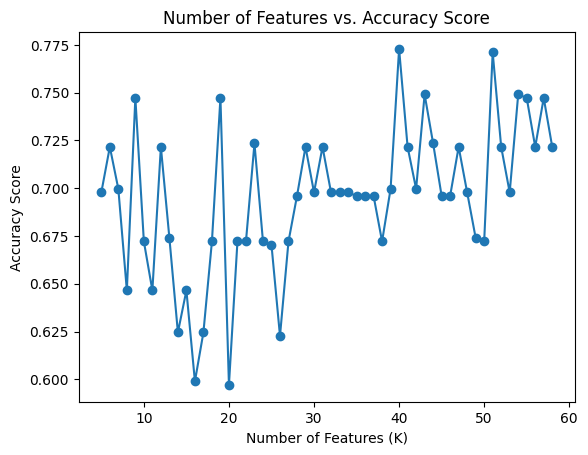

Index(['rank', 'confW', 'confL', 'total_first_round_won', 'total_semis_won',
       'total_semis_lost', 'total_finals_won', 'total_finals_lost',
       'mean_lost', 'confID_EA', 'confID_WE', 'GP', 'GS', 'minutes', 'PostGS',
       'PostMinutes', 'performance', 'Postperformance', 'points_precision',
       'Postpoints_precision', 'PostDQ', 'award_count_x', 'won', 'lost',
       'post_wins', 'post_losses', 'tmID_ATL', 'tmID_DET', 'tmID_HOU',
       'tmID_IND', 'tmID_LAS', 'tmID_MIA', 'tmID_MIN', 'tmID_NYL', 'tmID_SAC',
       'tmID_SAS', 'tmID_SEA', 'tmID_TUL', 'tmID_UTA', 'tmID_WAS', 'playoff',
       'year', 'tmID_CHA', 'tmID_CHI', 'tmID_CLE', 'tmID_CON', 'tmID_ORL',
       'tmID_PHO', 'tmID_POR'],
      dtype='object')


In [123]:
# Voting Ensemble
voting_clf = VotingClassifier(estimators=[
    ('model1', model1),
    ('model2', model2),
    ('model3', model3),
    ('model4', model4)
], voting='soft')

# Extract the target variable
target_variable = df_teams["playoff"]

# Fit the ensemble model
voting_clf.fit(df_teams, target_variable)

features_kbest = select_k_best(df_teams[df_teams["year"] < 11], voting_clf, scaling=True)
print(features_kbest)



In [124]:
data = df_teams[features_kbest]
target_col = "playoff"
# Split the data into training and test sets
train_data = data[data["year"] < 11]
train_data = train_data[train_data["year"] >= 11 - 4]
test_data = data[data["year"] == 11]

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
train_data = pd.DataFrame(train_data, columns=data.columns)
test_data = scaler.transform(test_data)
test_data = pd.DataFrame(test_data, columns=data.columns)

X_train = train_data.drop([target_col], axis=1)
y_train = train_data[target_col]
X_test = test_data.drop([target_col], axis=1)

voting_clf.fit(X_train, y_train)
y_prob = voting_clf.predict_proba(X_test)

test_data = test_data.copy()
test_data.loc[:, 'y_prob'] = y_prob[:, 1]
test_data['y_pred'] = 0
conferences = ['confID_EA', 'confID_WE']
for conf_col in conferences:
    conf_indices = test_data.index[test_data[conf_col] == 1].tolist()
    sorted_indices = np.argsort(
        -test_data['y_prob'].loc[test_data[conf_col] == 1].values).tolist()
    top_4_indices = [conf_indices[i] for i in sorted_indices[:4]]
    test_data.loc[top_4_indices, 'y_pred'] = 1
team_ids = ['tmID_TUL','tmID_ATL','tmID_CHA','tmID_CHI','tmID_CLE','tmID_CON','tmID_DET','tmID_HOU','tmID_IND','tmID_LAS','tmID_MIA','tmID_MIN','tmID_NYL','tmID_ORL','tmID_PHO','tmID_POR','tmID_SAC','tmID_SAS','tmID_SEA','tmID_UTA','tmID_WAS']
#remove one hot encoding. For each value in test_data check witch teams_ids are 1 and add the team to the tmID column
test_data['tmID'] = ""
for i in range(len(test_data)):
    for team in team_ids:
        if test_data[team].iloc[i] == 1:
            test_data.loc[i, 'tmID'] = team.split('_')[1]


# Add the 'year', 'y_pred', 'y_prob', and the original 'tmID' back to the DataFrame

test_data = test_data[['tmID', 'y_pred']]
#change tmID for ID
test_data['ID'] = test_data['tmID']
test_data.drop(columns=['tmID'], inplace=True)
#columns ID, label. Label is Y when y_pred is 1 and N when y_pred is 0
test_data['label'] = test_data['y_pred'].map({1: 'Y', 0: 'N'})
test_data.drop(columns=['y_pred'], inplace=True)

#sort by ID
test_data.sort_values(by=['ID'], ascending=[True], inplace=True)
test_data.to_csv('predictions.csv', index=False)